In [1]:
using Distributions
using HypothesisTests
using Random
using StatsBase
using StatsPlots
default(fmt=:png, titlefontsize=10)

safediv(x, y) = x==0 ? zero(x/y) : x/y

function pvalue_chisq(a, b, c, d)
    chi2 = safediv((a+b+c+d)*(a*d - b*c)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chi2)
end

function pvalue_fisher(a, b, c, d)
    pvalue(FisherExactTest(a, b, c, d); method=:minlike)
end

function npqrs(a, b, c, d; mode=:null)
    n = a+b+c+d
    if mode == :null
        p, q, r, s = (a+b)*(a+c)/n^2, (a+b)*(b+d)/n^2, (c+d)*(a+c)/n^2, (c+d)*(b+d)/n^2
    else
        p, q, r, s = a/n, b/n, c/n, d/n
    end
    n, p, q, r, s
end

function make_rand_poi4(a, b, c, d; mode=:null)
    n, p, q, r, s = npqrs(a, b, c, d; mode)
    poi = product_distribution(Poisson(n*p), Poisson(n*q), Poisson(n*r), Poisson(n*s))
    f!(tmp) = rand!(poi, tmp)
    f!
end

function make_rand_mult(a, b, c, d; mode=:null)
    n, p, q, r, s = npqrs(a, b, c, d; mode)
    mult = Multinomial(n, [p, q, r, s])
    f!(tmp) = rand!(mult, tmp)
    f!
end

function make_rand_bin2(a, b, c, d; mode=:null)
    if mode == :null
        p = q = (a+c)/(a+b+c+d)
    else
        p, q = a/(a+b), c/(c+d)
    end
    bin1, bin2 = Binomial(a+b, p), Binomial(c+d, q)
    function f!(tmp)
        x, y = rand(bin1), rand(bin2)
        x, a+b-x, y, c+d-y
    end
    f!
end

function sim(a, b, c, d; mode=:null, L=10^5, make_rand_func=make_rand_poi4)
    f! = make_rand_func(a, b, c, d; mode)
    pval_chisq = zeros(L)
    pval_fisher = zeros(L)
    Atmp = [zeros(Int, 4) for _ in 1:Threads.nthreads()]
    for i in 1:L
        tid = Threads.threadid()
        a, b, c, d = f!(Atmp[tid])
        pval_chisq[i] = pvalue_chisq(a, b, c, d)
        pval_fisher[i] = pvalue_fisher(a, b, c, d)
    end
    _ecdf_chisq = ecdf(pval_chisq)
    _ecdf_fisher = ecdf(pval_fisher)
    ecdf_chisq(x) = _ecdf_chisq(x)
    ecdf_fisher(x) = _ecdf_fisher(x)
    ecdf_chisq, ecdf_fisher
end

function plot_sim(a, b, c, d; mode=:null, L=10^5, make_rand_func=make_rand_poi4)
    ecdf_chisq, ecdf_fisher = sim(a, b, c, d; mode, L, make_rand_func)

    xtick = 0:0.01:1
    ytick = mode == :null ? (0:0.01:1) : (0:0.1:1)
    plot(; size=(400, 400))
    plot!(ecdf_chisq, 0, 0.1; label="ecdf_chisq")
    plot!(ecdf_fisher, 0, 0.1; label="ecdf_fisher")
    plot!(identity, 0, 0.1; label="", ls=:dot, c=:black)
    plot!(; xguide="α", yguide="probability of P-value ≤ α")
    plot!(; xtick, ytick)
    modelname = replace(string(make_rand_func), r"^make_rand_"=>"")
    title!("Model: $modelname($a, $b, $c, $d; mode=:$mode)")
end

function plot_sim_all(a, b, c, d; L=10^5)
    @show a, b, c, d
    @show pvalue_chisq(a, b, c, d)
    @show pvalue_fisher(a, b, c, d)
    n, p, q, r, s = npqrs(a, b, c, d; mode=:null)
    print("null expectation: ", (n*p, n*q, n*r, n*s))
    PP = []
    for make_rand_func in (make_rand_poi4, make_rand_mult, make_rand_bin2)
        P = plot_sim(a, b, c, d; mode=:null, L, make_rand_func)
        push!(PP, P)
        P = plot_sim(a, b, c, d; mode=:raw, L, make_rand_func)
        push!(PP, P)
    end
    plot!(PP...; size=(720, 1200), layout=(3, 2))
    plot!(; leftmargin=8Plots.mm, xrotation=30)
end

plot_sim_all (generic function with 1 method)

(a, b, c, d) = (2, 8, 7, 3)
pvalue_chisq(a, b, c, d) = 0.024618761380815177
pvalue_fisher(a, b, c, d) = 0.06977851869492736
null expectation: (4.5, 5.5, 4.5, 5.5)

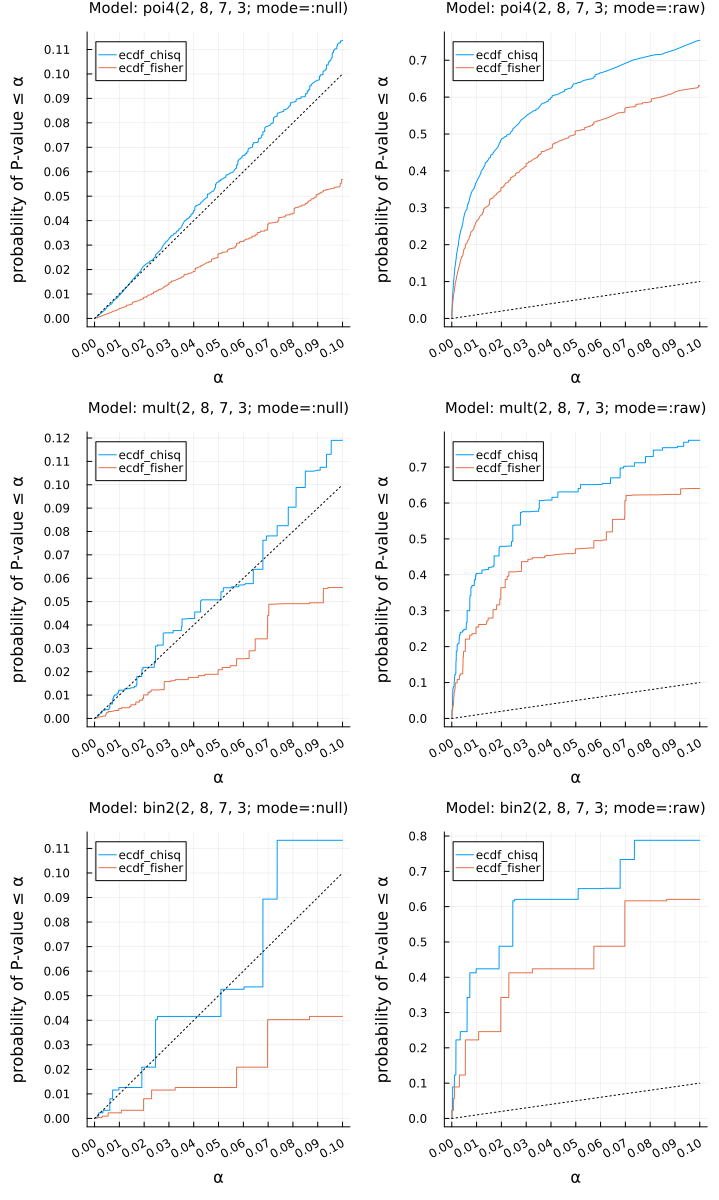

In [2]:
plot_sim_all(2, 8, 7, 3)

(a, b, c, d) = (4, 1, 1, 5)
pvalue_chisq(a, b, c, d) = 0.03568232934330229
pvalue_fisher(a, b, c, d) = 0.08008658008658008
null expectation: (2.272727272727273, 2.7272727272727275, 2.7272727272727275, 3.272727272727273)

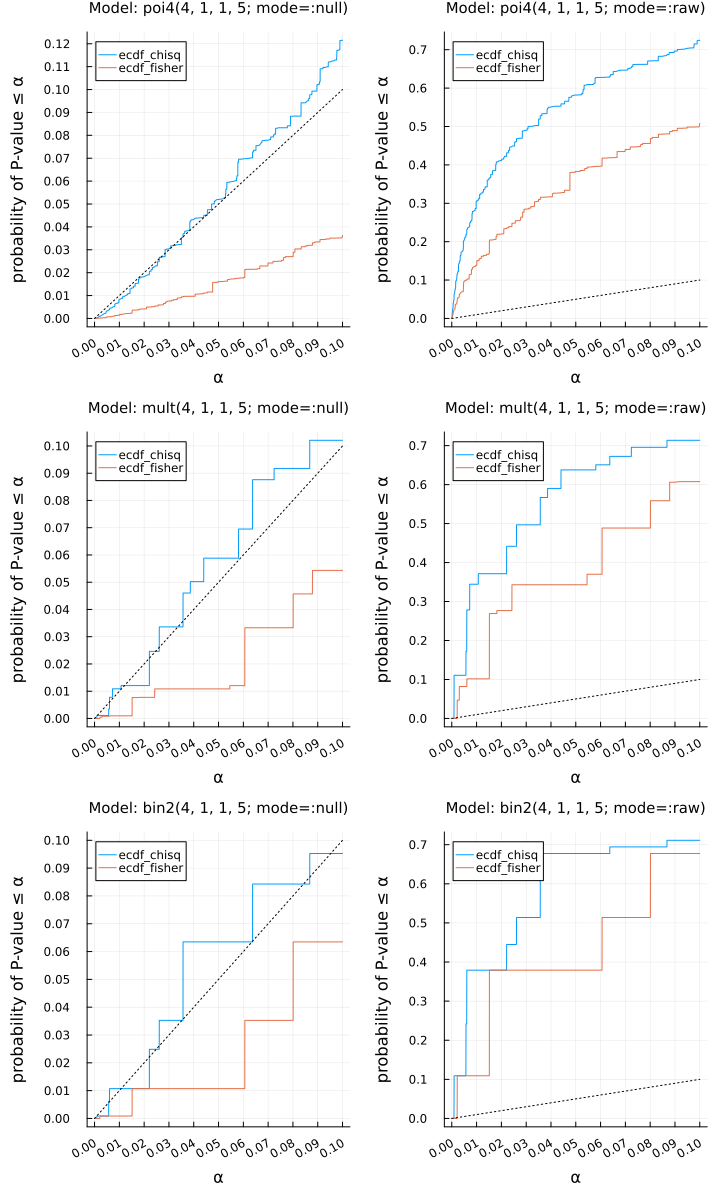

In [3]:
plot_sim_all(4, 1, 1, 5)